In [1]:
import numpy as np
import mne
import matplotlib.pyplot as plt
from scipy.signal import convolve

In [2]:
schizophrenic_epochs = mne.read_epochs(
    'processed_schizophrenic_eeg-epo.fif', preload=True)
healthy_epochs = mne.read_epochs('processed_healthy_eeg-epo.fif', preload=True)

Reading d:\research-reservoir\Schizo-hormone\processed_schizophrenic_eeg-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =       0.00 ...    1996.00 ms
        0 CTF compensation matrices available
Not setting metadata
15819 matching events found
No baseline correction applied
0 projection items activated
Reading d:\research-reservoir\Schizo-hormone\processed_healthy_eeg-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =       0.00 ...    1996.00 ms
        0 CTF compensation matrices available
Not setting metadata
13016 matching events found
No baseline correction applied
0 projection items activated


In [3]:
schizophrenic_data = schizophrenic_epochs.get_data()
healthy_data = healthy_epochs.get_data()

C:\Users\anisr\AppData\Local\Temp\ipykernel_18048\2828544710.py:1: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  schizophrenic_data = schizophrenic_epochs.get_data()
C:\Users\anisr\AppData\Local\Temp\ipykernel_18048\2828544710.py:2: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  healthy_data = healthy_epochs.get_data()


In [4]:
schizophrenic_data = schizophrenic_data.reshape(
    schizophrenic_data.shape[0], -1)
healthy_data = healthy_data.reshape(healthy_data.shape[0], -1)

In [5]:
schizophrenic_data = (schizophrenic_data - np.min(schizophrenic_data)) / \
    (np.max(schizophrenic_data) - np.min(schizophrenic_data))
healthy_data = (healthy_data - np.min(healthy_data)) / \
    (np.max(healthy_data) - np.min(healthy_data))

In [18]:
class NeuronModel:
    def __init__(self, Nn, Ne, Ni, dt, N, input_data):
        self.Nn = Nn  # Total neurons
        self.Ne = Ne  # Excitatory neurons
        self.Ni = Ni  # Inhibitory neurons
        self.dt = dt  # Time step
        self.N = N    # Number of time epochs
        self.input_data = input_data  # Input EEG data

        re = np.random.rand(Ne)
        ri = np.random.rand(Ni)

        self.a = np.concatenate([0.02 * np.ones(Ne//2), 0.02 + 0.08 *
                                ri[:Ni//2], 0.02 * np.ones(Ne//2), 0.02 + 0.08 * ri[Ni//2:]])
        self.b = np.concatenate([0.2 * np.ones(Ne//2), 0.25 - 0.05 *
                                ri[:Ni//2], 0.2 * np.ones(Ne//2), 0.25 - 0.05 * ri[Ni//2:]])
        self.c = np.concatenate([-65 + 15 * re[:Ne//2]**2, -65 *
                                np.ones(Ni//2), -65 + 15 * re[Ne//2:]**2, -65 * np.ones(Ni//2)])
        self.d = np.concatenate(
            [8 - 6 * re[:Ne//2]**2, 2 * np.ones(Ni//2), 8 - 6 * re[Ne//2:]**2, 2 * np.ones(Ni//2)])

        self.V = np.full((Nn, N), -95.0)  # Membrane potentials
        # Adjust initialization to avoid out-of-bounds error
        self.u = np.zeros((Nn, N))
        self.u[:, 0] = self.b * self.V[:, 0]
        self.Isyn = np.zeros((Nn, N))  # Synaptic currents
        self.woi = np.random.rand(Nn, Nn)  # Initial synaptic weights

    def new_spike_detection(self, inp_next, inp_curr, i, m_in, std_in, m_v, std_v):
        # Spike detection logic
        Xk = (inp_next - inp_curr) > np.random.rand(len(inp_next))  # Example logic
        return Xk, m_in, std_in, m_v, std_v

    def run_simulation(self):
        dt = self.dt
        for i in range(self.N-1):
            t = i * dt

            # Spike Detection
            Xk, m_in, std_in, m_v, std_v = self.new_spike_detection(
                self.input_data[:, i+1], self.input_data[:, i], i, m_in=-0.5, std_in=1, m_v=-0.3, std_v=1)

            # Update membrane potential and recovery variable
            dV = 0.04 * self.V[:, i]**2 + 5 * self.V[:, i] + \
                140 - self.u[:, i] + 10 * self.Isyn[:, i]
            du = self.a * (self.b * self.V[:, i] - self.u[:, i])
            self.V[:, i+1] = self.V[:, i] + dV * dt
            self.u[:, i+1] = self.u[:, i] + du * dt

            # Spike logic
            for j in range(self.Nn):
                if self.V[j, i+1] > 30:
                    self.V[j, i+1] = self.c[j]
                    self.u[j, i+1] += self.d[j]

            # Update synaptic weights
            # Convert booleans to float for numerical operations
            s = Xk.astype(float) - Xk.astype(float)
            for j in range(self.Nn):
                if s[j] <= 0:
                    adi = 0.1 * np.exp(s[j] / 5000)
                else:
                    adi = 0.1 * np.exp(-s[j] / 5000)

                self.woi[j, :] += adi

            # Synaptic currents update
            self.Isyn[:, i +
                      1] = self.woi.dot(np.exp(t / 5000) * np.ones(self.Nn))

        return self.V, Xk

In [33]:
N = 100
dt = 0.002
Ne = 72
Ni = 28
Nn = Ne + Ni

In [44]:
neuron_model_schizophrenic = NeuronModel(
    Nn=Nn, Ne=Ne, Ni=Ni, dt=dt, N=N, input_data=schizophrenic_data.T)
neuron_model_healthy = NeuronModel(
    Nn=Nn, Ne=Ne, Ni=Ni, dt=dt, N=N, input_data=healthy_data.T)

In [54]:
V_schizophrenic, Xk_schizophrenic = neuron_model_schizophrenic.run_simulation()
V_healthy, Xk_healthy = neuron_model_healthy.run_simulation()

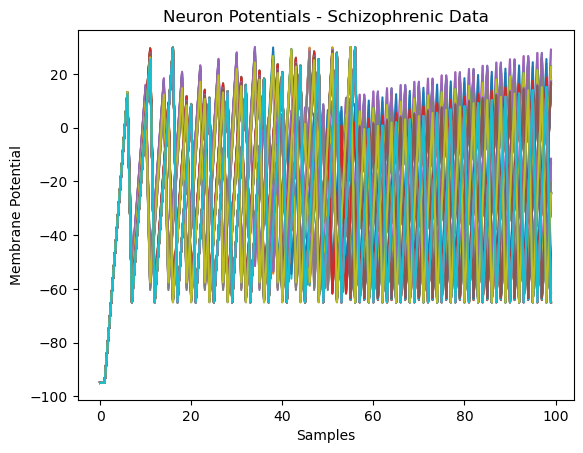

In [55]:
plt.figure(1)
plt.plot(V_schizophrenic.T)
plt.title('Neuron Potentials - Schizophrenic Data')
plt.xlabel('Samples')
plt.ylabel('Membrane Potential')
plt.show()

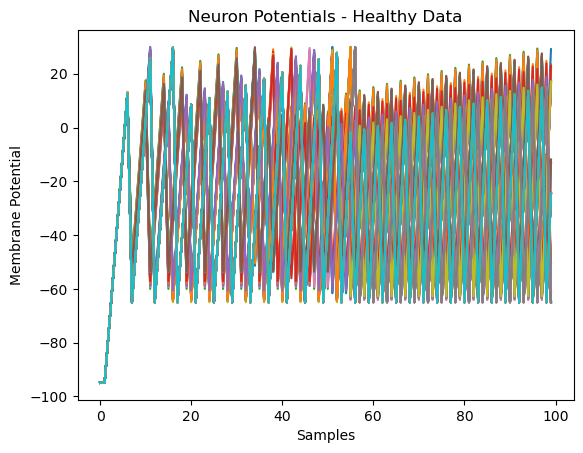

In [56]:
plt.figure(2)
plt.plot( V_healthy.T)
plt.title('Neuron Potentials - Healthy Data')
plt.xlabel('Samples')
plt.ylabel('Membrane Potential')
plt.show()

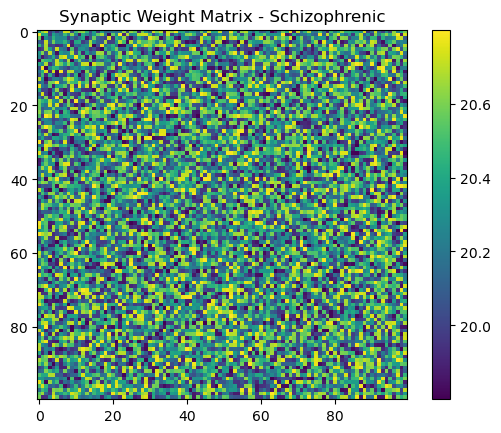

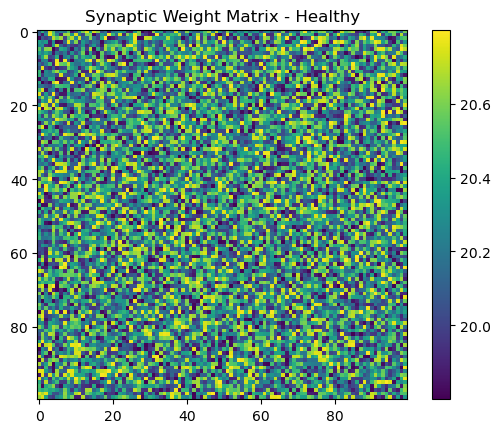

In [57]:
plt.figure(3)
plt.imshow(neuron_model_schizophrenic.woi, cmap='viridis')
plt.colorbar()
plt.title('Synaptic Weight Matrix - Schizophrenic')
plt.show()

plt.figure(4)
plt.imshow(neuron_model_healthy.woi, cmap='viridis')
plt.colorbar()
plt.title('Synaptic Weight Matrix - Healthy')
plt.show()

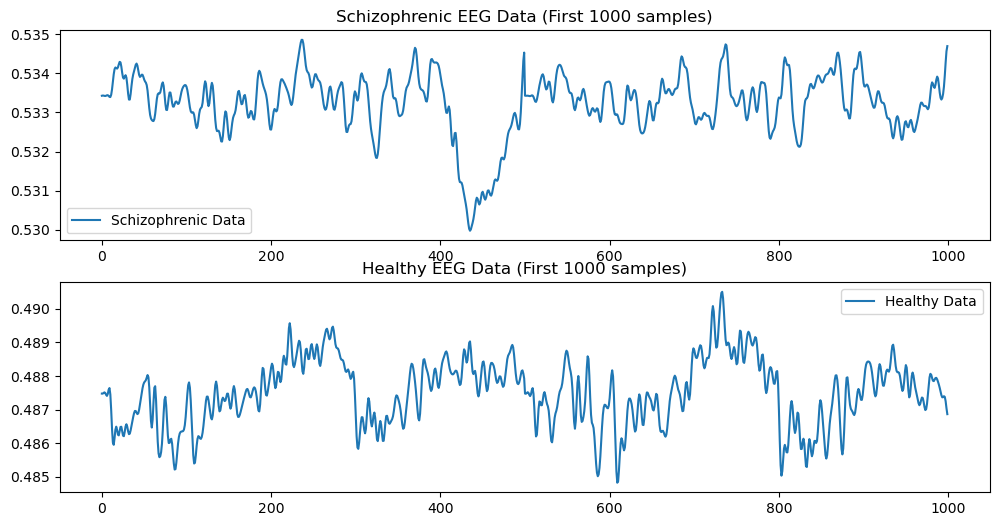

In [49]:
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(schizophrenic_data[0, :1000], label='Schizophrenic Data')
plt.title('Schizophrenic EEG Data (First 1000 samples)')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(healthy_data[0, :1000], label='Healthy Data')
plt.title('Healthy EEG Data (First 1000 samples)')
plt.legend()

plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


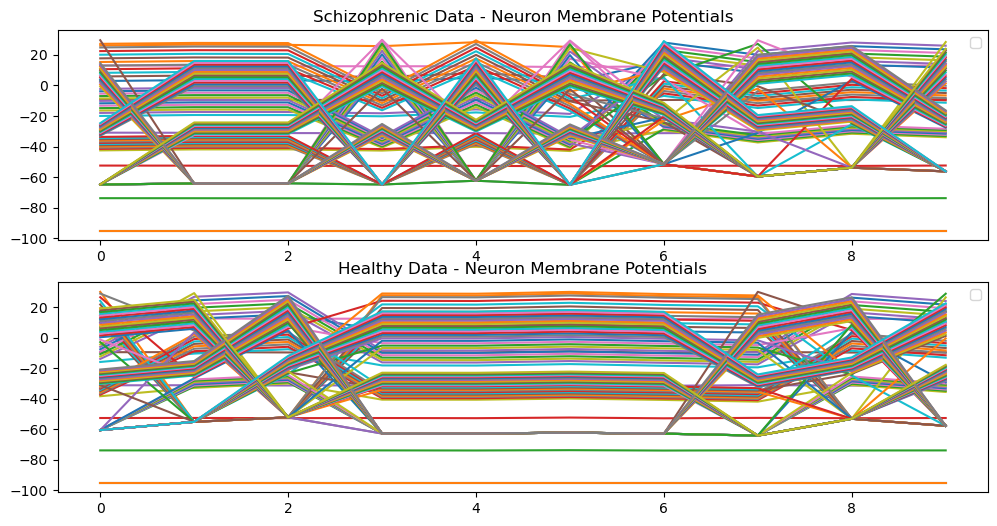

In [58]:
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(V_schizophrenic[:10, :])
plt.title('Schizophrenic Data - Neuron Membrane Potentials')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(V_healthy[:10, :])
plt.title('Healthy Data - Neuron Membrane Potentials')
plt.legend()

plt.show()

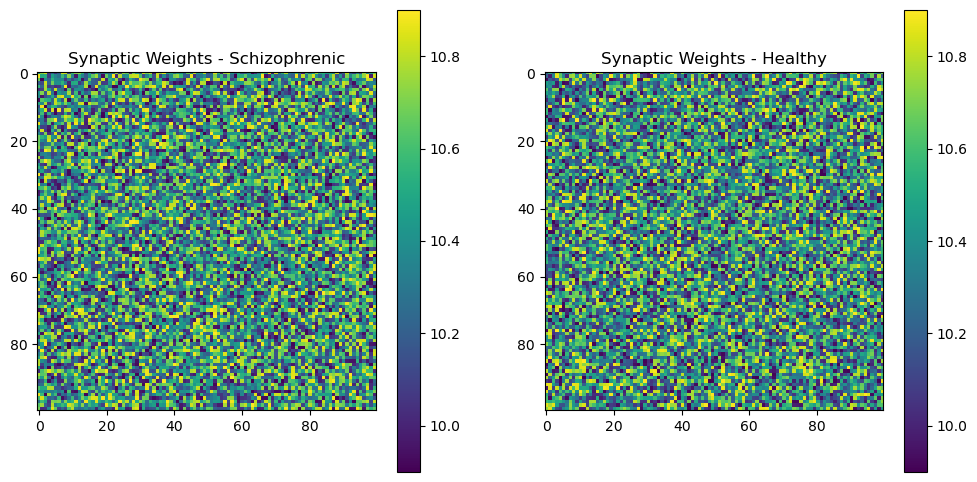

In [51]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(neuron_model_schizophrenic.woi, cmap='viridis')
plt.colorbar()
plt.title('Synaptic Weights - Schizophrenic')

plt.subplot(1, 2, 2)
plt.imshow(neuron_model_healthy.woi, cmap='viridis')
plt.colorbar()
plt.title('Synaptic Weights - Healthy')

plt.show()

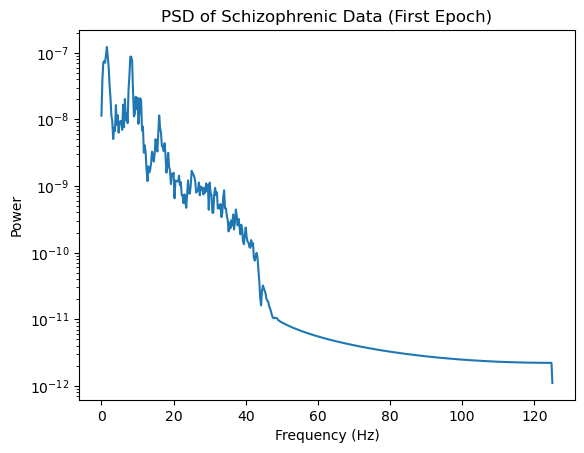

In [52]:
from scipy.signal import welch

f, Pxx = welch(schizophrenic_data[0], fs=250, nperseg=1000)
plt.semilogy(f, Pxx)
plt.title('PSD of Schizophrenic Data (First Epoch)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.show()

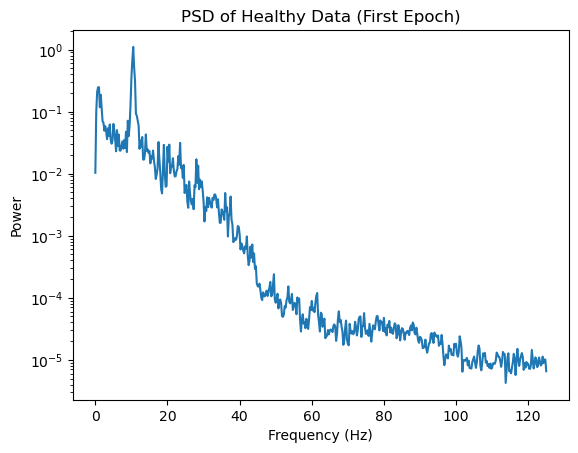

In [83]:
f, Pxx = welch(healthy_data
               [0], fs=250, nperseg=1000)
plt.semilogy(f, Pxx)
plt.title('PSD of Healthy Data (First Epoch)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.show()

In [84]:
import numpy as np
import mne
from reservoirpy.nodes import Reservoir, Ridge
from reservoirpy import Model

from reservoirpy import mat_gen
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [60]:
scaler = StandardScaler()
schizophrenic_data = scaler.fit_transform(schizophrenic_data)
healthy_data = scaler.fit_transform(healthy_data)

In [69]:
n_inputs = schizophrenic_data.shape[1]
n_reservoir = 500
n_outputs = n_inputs  
spectral_radius = 0.95
leak_rate = 0.3

In [86]:
reservoir = Reservoir(units = n_reservoir,lr=leak_rate,sr=spectral_radius)
readout = Ridge(ridge=1-5,output_dim=n_outputs)
model = reservoir >> readout

In [90]:
X_train = schizophrenic_data[:-100]
y_train = np.roll(X_train, -1, axis=0)

In [91]:
model.fit(X_train,y_train)

Running Model-1: 15719it [00:17, 919.89it/s]<?, ?it/s]
Running Model-1: 100%|██████████| 1/1 [00:20<00:00, 20.72s/it]


Fitting node Ridge-10...


'Model-1': Model('Reservoir-7', 'Ridge-10')

In [105]:
warmup_y = model.run(schizophrenic_data[-100:], reset=True)

Running Model-1: 100it [00:00, 203.22it/s]            


In [106]:
Y_pred = schizophrenic_data[-100:] 

In [107]:
x = warmup_y[-1].reshape(1, -1)

for i in range(100):
    x = model(x)
    Y_pred[i] = x

In [108]:
X_test = schizophrenic_data[-100:]

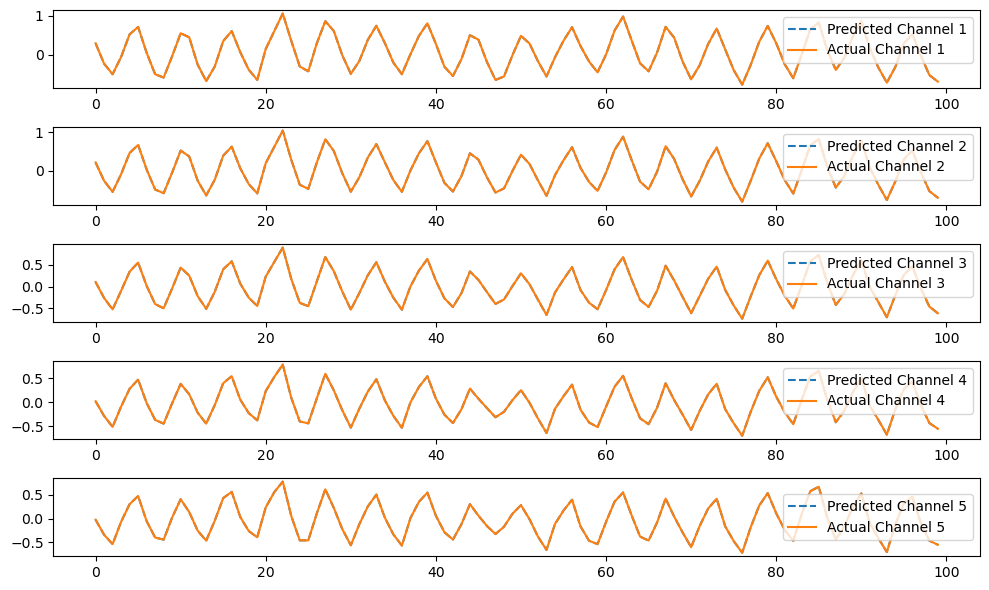

In [109]:
plt.figure(figsize=(10, 6))

# Compare the first few channels
for i in range(5):  # Plotting first 5 channels
    plt.subplot(5, 1, i + 1)
    plt.plot(Y_pred[:, i], label=f'Predicted Channel {i+1}', linestyle='--')
    plt.plot(X_test[:, i], label=f'Actual Channel {i+1}')
    plt.legend()

plt.tight_layout()
plt.show()